Package imports and dataset download

In [13]:
from matplotlib import pyplot as plt
from torch import pca_lowrank, tensor, float32
from torchvision.datasets import CIFAR10
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

cifar10 = CIFAR10(root='../data', train=True, download=True)
dataset = tensor(cifar10.data.copy().reshape(cifar10.data.shape[0], -1), dtype=float32)

Files already downloaded and verified


Plotting one image per class (32x32x3 dimensionality is 3072)

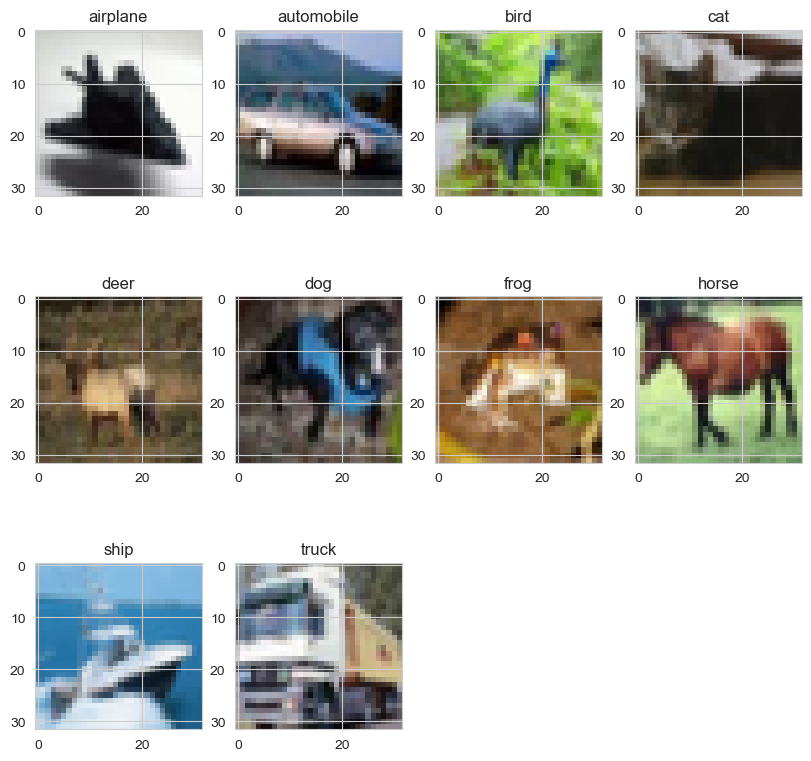

In [2]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
columns = 4
rows = 3

for img_class in range(10):
    img = cifar10.data[cifar10.targets.index(img_class)]
    fig.add_subplot(rows, columns, img_class + 1, title=cifar10.classes[img_class])
    plt.imshow(img)

Plotting images in 2 dimensions using PCA

/Users/leonardocandio/.conda/envs/lab3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, '2D PCA of CIFAR10 dataset')

<Figure size 1500x1500 with 0 Axes>

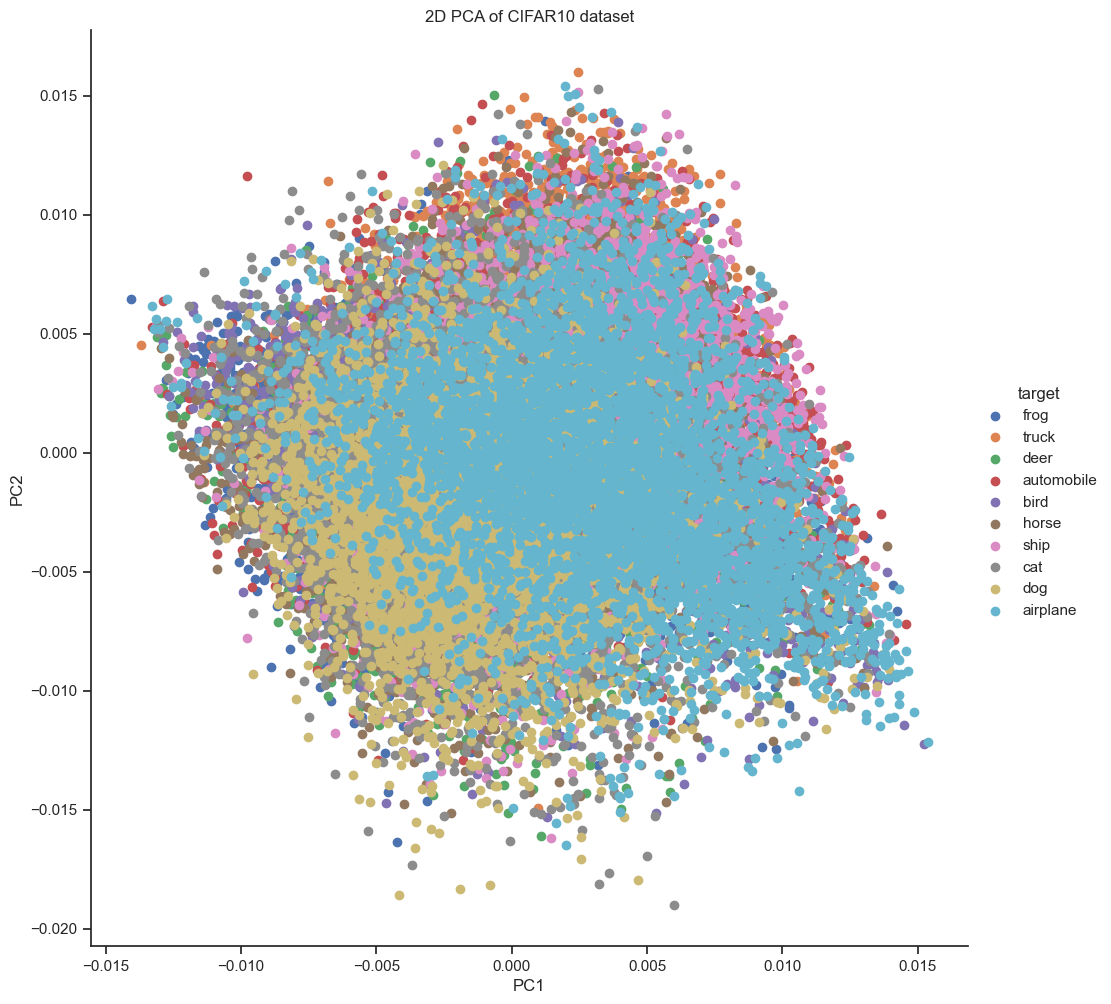

In [11]:
pcaU, pcaS, pcaV = pca_lowrank(dataset, 2)

sns.set(style="ticks")

pcaU = pd.DataFrame(pcaU, columns=['PC1', 'PC2'])
pcaU['target'] = [cifar10.classes[target] for target in cifar10.targets]

#using seaborn to plot the data
plt.figure(figsize=(15, 15))
sns.FacetGrid(pcaU, hue="target", height=10).map(plt.scatter, "PC1", "PC2").add_legend()

#TODO preguntarle al profe sobre como plottear los eigenvectors

plt.title('2D PCA of CIFAR10 dataset')


Adding embeddings and recalculating the PCA

In [ ]:
#TODO Agregar embeddings y recalcular el PCA

Calculating the t-SNE

In [21]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dataset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.200s...
[t-SNE] Computed neighbors for 50000 samples in 100.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for 

/Users/leonardocandio/.conda/envs/lab3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1500 with 0 Axes>

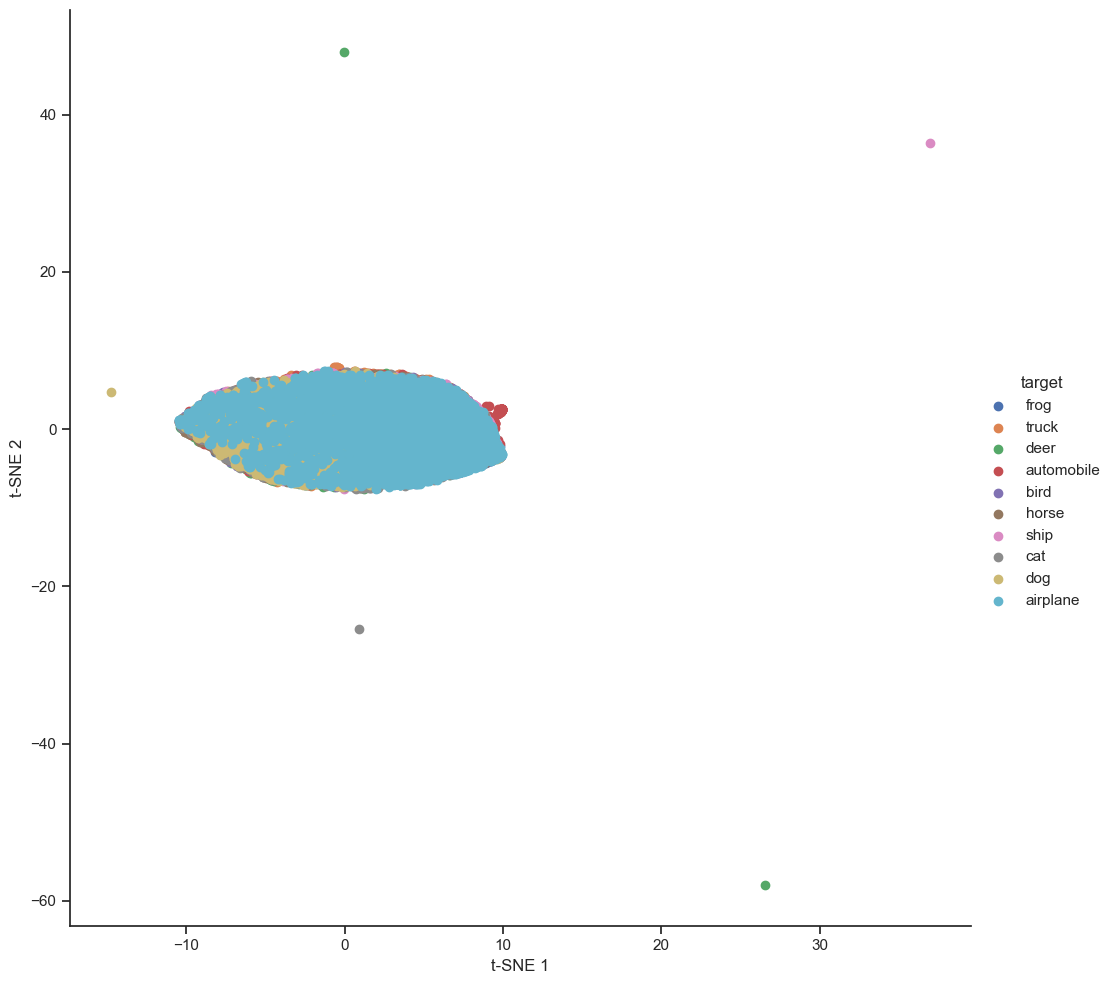

In [22]:
#TODO PREGUNTAR PORQUE SE VE TAN MAL

plt.figure(figsize=(15, 15))
tsne_results = pd.DataFrame(tsne_results, columns=['t-SNE 1', 't-SNE 2'])
tsne_results['target'] = [cifar10.classes[target] for target in cifar10.targets]

sns.FacetGrid(tsne_results, hue="target", height=10).map(plt.scatter, 't-SNE 1', 't-SNE 2').add_legend()

|